In [1]:
%reload_ext autoreload
%autoreload 2

#**Практическое задание №1**

Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [2]:
GPU = "cuda:5"

In [3]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [4]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown
import os
import gc
from skimage import feature
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [5]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        if not os.path.exists(output):
            gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    @staticmethod
    def hist_feature(image):
        radius = 4
        n_points = 8 * radius
        n_bins = 32
        gray = image.mean(axis=-1).astype("uint8")
        lbp = feature.local_binary_pattern(gray, n_points, radius, method="uniform")
        hist1, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
        hist2 = np.array([np.histogram(image[..., i].ravel(), bins=n_bins)[0] for i in range(3)]).ravel()
        return np.concatenate([hist1, hist2])

    def to_hist_feature(self):
        print("Building histogram features...")
        if not hasattr(self, "histogram_features"):
            try:
                from joblib import Parallel, delayed
                results = Parallel(n_jobs=-1)(delayed(self.hist_feature)(x) for x in self.images)
                self.histogram_features = np.array(results)
            except:
                self.histogram_features = np.array([self.hist_feature(x) for x in tqdm(self.images)])
        return self.histogram_features

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
        
    def sample(self, ratio=0.5):
        return self.random_batch_with_labels(n=round(self.images.shape[0] * ratio))
        
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits
        
    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 1.
Label code corresponds to BACK class.


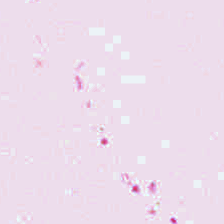

In [6]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [8]:
# Вариант модели 1: Случайный лес
class Model:

    def __init__(self, random_state=0):
        self.random_state = random_state
        self.estimator = RandomForestClassifier(
            n_estimators=10, max_depth=None, min_samples_split=5, min_samples_leaf=5,
            oob_score=False, n_jobs=-1, max_samples=0.75, warm_start=True, random_state=random_state)

    def save(self, name: str = "one_model"):
        with open(name, "wb") as handler:
            pickle.dump(self.estimator, handler)
    
    def load(self, name: str = None):
        if name == None:
            name = "https://drive.google.com/uc?id=1RQCcKRlcPMoVTIlniF5YT9hx-e2AtKrK"
        if os.path.exists(name): # load as file
            with open(name, "rb") as handler:
                self.estimator = pickle.load(handler)
            return self
        else: # load a google drive file
            output = "rf_big_model.pickle"
            gdown.download(name, output, quiet=False)
            return self.load(output)

    # Кросс-валидация по каждому из параметров отдельно #LBL2
    # Запускалось отдельно для проставления в ___init__ ввиду длительности работы
    # Автоматический подбор гиперпараметров  #LBL7
    def find_best_params(self, grid, dataset:Dataset, cv=3):
        result = {}
        X = dataset.to_hist_feature() # Если удается то параллельно, но тогда не будет прогресса видно...
        y = dataset.labels #LBL1
        print("Grid search for best params...")
        for param, values in tqdm(grid.items()):
            result[param] = GridSearchCV(self.estimator, param_grid=grid, cv=cv).fit(X, y).best_params_[param]
        return result

    # Установить заданные параметры в модель
    def set_params(self, params): #LBL7
        self.estimator.set_params(**params)
    
    @staticmethod
    def name_iter(i):
        return "model_iter_" + str(i)

    # Загружаем модель с итерации (не все доступны, только улучшающие - для экономии времени работы)
    def load_iter(self, i):
        return self.load(self.name_iter(i))  #LBL4

    # Сохраняем модель с итерации
    def save_iter(self, i):
        return self.save(self.name_iter(i)) 

    # Простые аугментации не подходят ввиду выбора классических признаков
    def train(self, dataset: Dataset, train_size: float = 0.75, max_trees: int = 200):
        print(f'training started')
        X = dataset.to_hist_feature() # Если удается то параллельно, но тогда не будет прогресса видно...
        y = dataset.labels
        # LBL1
        X_train, X_val, y_train, y_val = \
            train_test_split(X, y, shuffle=True, train_size=train_size, stratify=y, random_state=self.random_state)
        # Используем валидационную выборку для подбора числа деревьев
        best_score = 0
        best_iter = 0
        history_train = []
        history_val = []
        model = clone(self.estimator)
        step = 5
        print("fitting model...")
        for i in tqdm(range((max_trees - model.n_estimators) // step)):
            model.fit(X_train, y_train)
            model.n_estimators += step # Добавляем 5 деревьев к ансамблю
            val_score = model.score(X_val, y_val)
            train_score = model.score(X_train, y_train)
            history_train.append(val_score) # Сохраняем историю тестирования на валидации
            history_val.append(train_score) # Сохраняем историю тестирования на тренировочной выборке
            print("Trees:", model.n_estimators, "| Score:", val_score) # #LBL5 Вывод информации об итерациях
            if best_score < val_score: # Тестируем на валидационной выборке на каждой итерации #LBL7
                best_score = val_score
                best_iter = i
                self.estimator = model
                self.save_iter(i) # #LBL3 Автоматически сохраняем итерацию что улучшает качество
        self.load_iter(best_iter) # Загружаем лучшую итерацию #LBL4
        plt.plot(history_train, label="train") # График качества от числа деревьев #LBL6
        plt.plot(history_val, label="validation") # График качества от числа деревьев #LBL6
        plt.legend() #LBL6
        plt.show()
        Metrics.print_all(y_train, self.estimator.predict(X_train), 'train')
        Metrics.print_all(y_val, self.estimator.predict(X_val), 'validation')
        # Здесь можно было бы обучить модель на всем тренировочном наборе
        print(f'training done')

    def test_on_dataset(self, dataset: Dataset, limit=None):
        X = dataset.to_hist_feature()
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        X = X[:n]
        predictions = self.estimator.predict(X)
        return predictions
    
    def test_on_image(self, img: np.ndarray):
        prediction = np.self.estimator.predict(img[np.newaxis])[0]
        return prediction

    def eval(self, dataset: Dataset, label="test"):
        prediction = self.test_on_dataset(dataset)
        Metrics.print_all(dataset.labels, prediction, label)

# Проверка загрузки

In [9]:
tiny_train = Dataset('train_tiny')
tiny_test = Dataset('test_tiny')

Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.
Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


In [10]:
model_loaded = Model().load()
model_loaded.eval(tiny_test)

Downloading...
From: https://drive.google.com/uc?id=1RQCcKRlcPMoVTIlniF5YT9hx-e2AtKrK
To: /home/n.onezhko/cvcourse/rf_big_model.pickle
100%|██████████| 29.8M/29.8M [00:00<00:00, 70.5MB/s]

Building histogram features...


metrics for test:
	 accuracy 0.9111:
	 balanced accuracy 0.9111:


In [11]:
model_loaded.estimator

RandomForestClassifier(criterion='entropy', max_samples=0.75,
                       min_samples_leaf=5, min_samples_split=5,
                       n_estimators=210, n_jobs=-1, random_state=42,
                       warm_start=True)

# Обучаем модель (Проверка что работает)

In [12]:
small_train = Dataset('train_small')
small_test = Dataset('test_small')

Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.
Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


In [13]:
classic = Model(random_state=0)

In [14]:
best_params = classic.find_best_params(grid=dict(
    #min_samples_split=[5, 10],
    #min_samples_leaf=[5, 10, 20, 30],
    #max_depth=[2, 4, None],
    #max_leaf_nodes=[2, 4, 8, 16, 32, None],
    #max_samples=[0.25, 0.5, 0.75],
    criterion=["gini", "entropy", "log_loss"]
), dataset=small_train)
best_params

Building histogram features...
Grid search for best params...


  0%|          | 0/1 [00:00<?, ?it/s]

{'criterion': 'entropy'}

In [15]:
classic.set_params(best_params)

training started
Building histogram features...
fitting model...


  0%|          | 0/18 [00:00<?, ?it/s]

Trees: 15 | Score: 0.855
Trees: 20 | Score: 0.8555555555555555
Trees: 25 | Score: 0.8588888888888889
Trees: 30 | Score: 0.8655555555555555
Trees: 35 | Score: 0.8683333333333333
Trees: 40 | Score: 0.8694444444444445
Trees: 45 | Score: 0.8722222222222222
Trees: 50 | Score: 0.8688888888888889
Trees: 55 | Score: 0.8727777777777778
Trees: 60 | Score: 0.8694444444444445
Trees: 65 | Score: 0.8705555555555555
Trees: 70 | Score: 0.87
Trees: 75 | Score: 0.8694444444444445
Trees: 80 | Score: 0.8744444444444445
Trees: 85 | Score: 0.8744444444444445
Trees: 90 | Score: 0.8744444444444445
Trees: 95 | Score: 0.8738888888888889
Trees: 100 | Score: 0.875


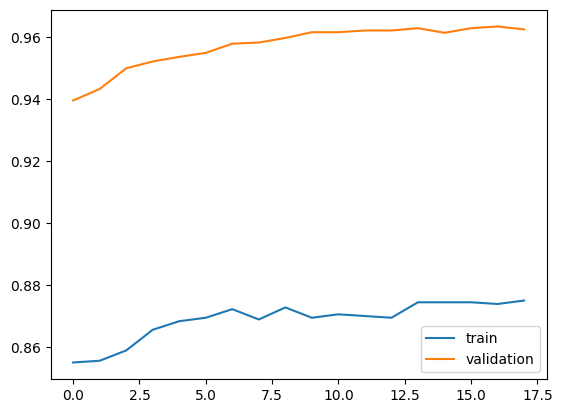

metrics for train:
	 accuracy 0.9626:
	 balanced accuracy 0.9626:
metrics for validation:
	 accuracy 0.8750:
	 balanced accuracy 0.8750:
training done
Building histogram features...
metrics for test:
	 accuracy 0.8622:
	 balanced accuracy 0.8622:


In [16]:
classic.train(small_train, max_trees=100)
classic.eval(small_test)

# Итоговая модель

In [17]:
big_train = Dataset('train')
big_test = Dataset('test')

Loading dataset train from npz.
Done. Dataset train consists of 18000 images.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [18]:
classic_big = Model(random_state=42)
classic_big.set_params(best_params)

training started
Building histogram features...
fitting model...


  0%|          | 0/78 [00:00<?, ?it/s]

Trees: 15 | Score: 0.878
Trees: 20 | Score: 0.8822222222222222
Trees: 25 | Score: 0.8886666666666667
Trees: 30 | Score: 0.8913333333333333
Trees: 35 | Score: 0.8928888888888888
Trees: 40 | Score: 0.8937777777777778
Trees: 45 | Score: 0.896
Trees: 50 | Score: 0.8951111111111111
Trees: 55 | Score: 0.8953333333333333
Trees: 60 | Score: 0.8966666666666666
Trees: 65 | Score: 0.8966666666666666
Trees: 70 | Score: 0.898
Trees: 75 | Score: 0.898
Trees: 80 | Score: 0.8977777777777778
Trees: 85 | Score: 0.8991111111111111
Trees: 90 | Score: 0.8988888888888888
Trees: 95 | Score: 0.898
Trees: 100 | Score: 0.8995555555555556
Trees: 105 | Score: 0.8986666666666666
Trees: 110 | Score: 0.8982222222222223
Trees: 115 | Score: 0.9
Trees: 120 | Score: 0.8984444444444445
Trees: 125 | Score: 0.8982222222222223
Trees: 130 | Score: 0.8975555555555556
Trees: 135 | Score: 0.898
Trees: 140 | Score: 0.8986666666666666
Trees: 145 | Score: 0.8971111111111111
Trees: 150 | Score: 0.8991111111111111
Trees: 155 | Score

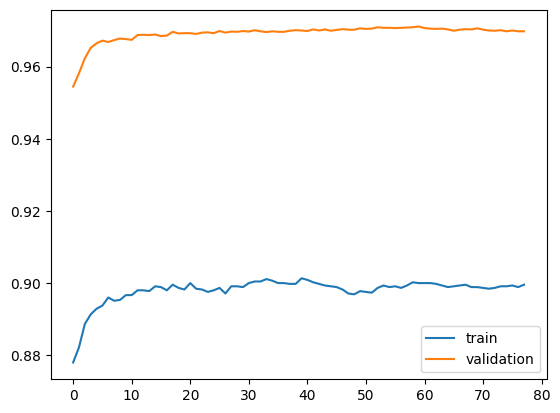

metrics for train:
	 accuracy 0.9700:
	 balanced accuracy 0.9700:
metrics for validation:
	 accuracy 0.9013:
	 balanced accuracy 0.9013:
training done


In [19]:
classic_big.train(big_train, max_trees=400)

In [20]:
classic_big.eval(big_test)

Building histogram features...
metrics for test:
	 accuracy 0.9013:
	 balanced accuracy 0.9013:


In [21]:
classic_big.save("rf_big_model")